# Preliminaries

In [1]:
# Required standard libraries
import pandas as pd
import json
import urllib
import requests
import os
import re
import numpy as np
import bs4 as bs
import selenium
import html5lib
#import nltk
import datetime
from selenium import webdriver

# Extractors 
import extract

# Cleansers (cluster specific)
import cleanse

# Normalizer (generalised across all clusters)
from normalize import scaler

# Utils
from utils import utils

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Define filepaths

In [2]:
# Define the export path for all data exports
from pathlib import Path

# Current working directory
cwd = Path('.')

# Folder with data-in artifacts, quired to run this script
data_in = cwd / 'data_in'

# Folder containing manually extracted raw data, ready to be put in the loop
data_sources_staged_raw = cwd / 'data_out' / 'data_staged_raw'
data_sources_staged_raw.mkdir(parents=True, exist_ok=True)

# Folder to export raw data
data_sources_raw = cwd / 'data_out' / 'data_raw'
data_sources_raw.mkdir(parents=True, exist_ok=True)

# Folder to export cleansed data
data_sources_cleansed = cwd / 'data_out' / 'data_cleansed'
data_sources_cleansed.mkdir(parents=True, exist_ok=True)

# Folder to export normalized data
data_sources_normalized = cwd / 'data_out' / 'data_normalized'
data_sources_normalized.mkdir(parents=True, exist_ok=True)

## Load country list and mapping dictionary

In [3]:
# Load the list of countries which contains all different variations of country names 
country_full_list = pd.read_excel(
    data_in / 'all_countrynames_list.xlsx',
    keep_default_na = False).drop_duplicates()

# Create a version of the list with unique ISO2 and ISO3 codes
country_iso_list = country_full_list.drop_duplicates(subset = 'COUNTRY_ISO_2')

# Country CRBA list, this is the list of the countries that should be in the final CRBA indicator list
country_crba_list = pd.read_excel(
    data_in / 'crba_country_list.xlsx',
    header = None,
    usecols = [0, 1], 
    names = ['COUNTRY_ISO_3', 'COUNTRY_NAME']).merge(
        right = country_iso_list[['COUNTRY_ISO_2', 'COUNTRY_ISO_3']],
        how = 'left',
        on='COUNTRY_ISO_3',
        validate = 'one_to_one')

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'column_mapping.py') as file:
    exec(file.read())

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'value_mapping.py') as file:
    exec(file.read())

## Read data dictionary

In [4]:
# sources sheet
crba_data_dictionary_source = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Source",
    keep_default_na = False
)

# snapshot sheet
crba_data_dictionary_snapshot = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Snapshot",
    keep_default_na = False
)

# indicator sheet
crba_data_dictionary_indicator = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Indicator",
    keep_default_na = False
)

# Input lists
crba_data_dictionary_input_list = pd.read_excel(
    data_in / 'indicator_dictionary_CRBA.xlsx',
    sheet_name = "Input_Lists",
    keep_default_na = False
)

# Add 2-digit shortcodes of index, issue and category to indicators sheet
crba_data_dictionary_indicator = crba_data_dictionary_indicator.merge(
    right=crba_data_dictionary_input_list[['INDEX', 'INDEX_CODE']],
    left_on='INDEX',
    right_on='INDEX'
).merge(
    right=crba_data_dictionary_input_list[['ISSUE', 'ISSUE_CODE']],
    left_on='ISSUE',
    right_on='ISSUE'
).merge(
    right=crba_data_dictionary_input_list[['CATEGORY', 'CATEGORY_CODE']],
    left_on='CATEGORY',
    right_on='CATEGORY'
)

# Create indicator code prefix (INDEX-ISSUE_CAEGORY CODE)
crba_data_dictionary_indicator = crba_data_dictionary_indicator.assign(
    INDICATOR_CODE_PREFIX = crba_data_dictionary_indicator.INDEX_CODE +
    "_" +
    crba_data_dictionary_indicator.ISSUE_CODE+
    "_"+
    crba_data_dictionary_indicator.CATEGORY_CODE+
    "_")

# Create indicator code
crba_data_dictionary_indicator = crba_data_dictionary_indicator.assign(
    INDICATOR_CODE = crba_data_dictionary_indicator.INDICATOR_CODE_PREFIX + crba_data_dictionary_indicator.INDICATOR_NAME.apply(
    lambda x: utils.create_ind_code(x)
))

In [ ]:
import importlib, inspect

extractors = { 
    cls.type: cls for name, cls in inspect.getmembers(
        importlib.import_module("extract"), 
        inspect.isclass
    ) if hasattr(cls, 'type')
}

# Staging (pre-processing) to create exceptional indicators´ raw data 

#

In [45]:
# Pre-processing of exceptional indicators, which require extra transformation
# Important: File requires having filepaths from above defined and pandas already imported
with open(data_in / 'staging_create_raw_data.py') as file:
    exec(file.read())

The following columns are present in the datasets, and this is the number of unique values they have. 
The column goal has 3 unique values.
The column target has 3 unique values.
The column indicator has 3 unique values.
The column series has 1 unique values.
The column seriesDescription has 1 unique values.
The column seriesCount has 1 unique values.
The column geoAreaCode has 98 unique values.
The column geoAreaName has 98 unique values.
The column timePeriodStart has 15 unique values.
The column value has 599 unique values.
The column valueType has 1 unique values.
The column time_detail has 1 unique values.
The column timeCoverage has 1 unique values.
The column upperBound has 1 unique values.
The column lowerBound has 1 unique values.
The column basePeriod has 1 unique values.
The column source has 1 unique values.
The column geoInfoUrl has 1 unique values.
The column footnotes has 1 unique values.
The column attributes.Nature has 1 unique values.
The column attributes.Units has 1

# Extract - Transform - Load Loop
## API sources
### CSV API sources

In [13]:
# CSV sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (ILO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (UNESCO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (WHO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (UNICEF)")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# # # # # # # # # # # #
# Delete again (only for temporary debugging 12.11.20)
# # # # # # # # # # # # 
# api_sources = api_sources[api_sources["SOURCE_ID"] == 'S-101']

# define emty dataframe
combined_cleansed_csv = pd.DataFrame()
combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Extraction section
    try:
        # Extract data
        dataframe = extract.CSVExtractor.extract(url = row["ENDPOINT_URL"])
        
        # Save raw data
        dataframe.to_csv(
            data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
            sep = ";"
            )
    
    except:
       print("There was a problem with extraction of source {} \n".format(row["SOURCE_ID"]))
    
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing
    dataframe = cleanse.Cleanser().extract_who_raw_data(
        raw_data=dataframe,
        variable_type = row["VALUE_LABELS"],
        display_value_col="Display Value"
    )
    
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
        dataframe=dataframe,
        year_col="TIME_PERIOD",
        time_cov_col="COVERAGE_TIME"
    )

    dataframe = cleanse.Cleanser().retrieve_latest_observation(
        renamed_data=dataframe,
        dim_cols = sdmx_df_columns_dims,
        country_cols = sdmx_df_columns_country,
        time_cols = sdmx_df_columns_time,
        attr_cols=sdmx_df_columns_attr,
    )

    # print(dataframe)

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe = cleanse.Cleanser().map_values(
        cleansed_data = dataframe,
        value_mapping_dict = value_mapper
    )
    
    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    cleanse.Cleanser().create_log_report(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )

lumn PUBLISHSTATE has 1 unique values.
The column YEAR has 4 unique values.
The column REGION has 7 unique values.
The column COUNTRY has 194 unique values.
The column Display Value has 6 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column Comments has 6 unique values.

 - - - - - 
 Cleansing source S-137 


 Calling function 'extract_who_raw_data'...

 Calling function 'rename_and_discard_columns'...

 Calling function 'extract_year_from_timeperiod'...

 Calling function 'retrieve_latest_observation'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'map_values'...
Values of column: DIM_SEX couldn't be mapped. If column DIM_SEX is present, there is an error with the code. 
Values of column: DIM_EDU_LEVEL couldn't be mapped. If column DIM_EDU_LEVEL is present, there is an error with the code. 
Values of column: DIM_AGE couldn't be mapp

### JSON API sources

In [17]:
# JSON sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (SDG)")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    try:
        # Extract data 
        dataframe = extract.JSONExtractor.extract(url = row["ENDPOINT_URL"])
        
        # Save dataframe
        dataframe.to_csv(
            data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
            sep = ";")
    except:
        print("There was an issue with source {}".format(row["SOURCE_ID"]))
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing in 
    dataframe = cleanse.Cleanser().extract_who_raw_data(
        raw_data=dataframe,
        variable_type = row["VALUE_LABELS"],
        display_value_col="Display Value"
    )
    
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().extract_year_from_timeperiod(
        dataframe=dataframe,
        year_col="TIME_PERIOD",
        time_cov_col="COVERAGE_TIME"
    )

    dataframe = cleanse.Cleanser().retrieve_latest_observation(
        renamed_data=dataframe,
        dim_cols = sdmx_df_columns_dims,
        country_cols = sdmx_df_columns_country,
        time_cols = sdmx_df_columns_time,
        attr_cols=sdmx_df_columns_attr,
    )

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe = cleanse.Cleanser().map_values(
        cleansed_data = dataframe,
        value_mapping_dict = value_mapper
    )
    
    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    cleanse.Cleanser().create_log_report(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )

EASURE

 Calling function 'encode_categorical_variables'...
Cleansing done. This is some basic information about the data: 
 
 There are 391 rows in the dataframe and 24.81% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     391.000000
mean     2017.092072
std         3.225971
min      2007.000000
25%      2016.000000
50%      2018.000000
75%      2019.000000
max      2020.000000
Name: TIME_PERIOD, dtype: float64

 - - - - - 
 Extracting source S-186 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column goal has 1 unique values.
The column target has 1 unique values.
The column indicator has 1 unique values.
The column series has 1 unique values.
The column seriesDescription has 1 unique values.
The column seriesCount has 1 unique values.
The column geoAreaCode has 95 unique values.
The column geoAreaName has 95 unique values.
The column timePeriodStart has 15 unique v

KeyError: 'COUNTRY_ISO_3'

## HTML Sources
### UN Treaty Sources

In [18]:
# UN Treaty HTML sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_BODY"] == "UN Treaties")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    dataframe = extract.HTMLExtractor().extract(url = row["ADDRESS"])
    
    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")

    # Cleansing
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    # Cleansing
    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        source_title_string=row["SOURCE_TITLE"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
        dataframe = dataframe,
        treaty_source_body = row["SOURCE_BODY"]
    )

    cleanse.Cleanser().create_log_report(
        cleansed_data=dataframe_cleansed
    )

    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")
    
    # Normalizing section
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )
    
    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )


 - - - - - 
 Extracting source S-4 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column Participant has 180 unique values.
The column Signature has 35 unique values.
The column Ratification, Acceptance(A), Approval(AA), Accession(a), Succession(d) has 172 unique values.

 - - - - - 
 Cleansing source S-4 


 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...

 Calling function 'encode_ilo_un_treaty_data'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: TIME_PERIOD, dtype: float64

 - - - - - 
 Extracting source S-31 

The following columns 

## Other sources
### WPA sources

In [19]:
# 1. Create a flat file of all WPA sources
# Read and join all world policy analysis centre data
wpa_child_labor = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_8, S_9' / 'WORLD_child_labor.xls'
)

wpa_childhood = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_10, S_13, S_36, S_45, S_49' / 'WORLD_Dataset_Childhood_4.16.15.xls'
)

wpa_adult_labor = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_40, S_41, S_63, S_64, S_65, S_66, S_67, S_68' / 'WORLD_Dataset_Adult_Labor_9.17.2018.xls'
)

wpa_discrimination = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_42, S_43, S_44' / 'WORLD_discrimination_at_work.xls'
)

# Create list to write a loop
wpa_combined_list=[
    wpa_childhood,
    wpa_adult_labor,
    wpa_discrimination
 ]

# Loop to join all dataframes
wpa_combined = wpa_child_labor

for df in wpa_combined_list:
    wpa_combined = wpa_combined.merge(
        right=df,
        on=['iso2', 'iso3']
    )

# 2. Loop
wpa_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_BODY"] == "World Policy Analysis Centre")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# Loop to extract data from API sources
for index, row in wpa_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    #try:
    # Extract data 
    # Log that we are entering cleasning
    print("\n Extracting data and store it as raw data")

    dataframe = wpa_combined[['iso3', row['WPA_OBS_RAW_COL']]] 
    dataframe['TIME_PERIOD'] = row['WPA_YEAR_COL'] 

    print(dataframe.head(30))

    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")
    #except:
    print("There was an issue with source {}".format(row["SOURCE_ID"]))
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing 
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    print(dataframe['RAW_OBS_VALUE'].unique())

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    cleanse.Cleanser().create_log_report(
        cleansed_data=dataframe_cleansed
    )

    
    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )
    

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")

    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )

    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )

ction 'encode_categorical_variables'...
Cleansing done. This is some basic information about the data: 
 
 There are 195 rows in the dataframe and 0.0% have a NA-value in the column 'OBS_RAW_VALUE

 
 This is the summary of the column 'TIME_PERIOD': count     195.0
mean     2020.0
std         0.0
min      2020.0
25%      2020.0
50%      2020.0
75%      2020.0
max      2020.0
Name: TIME_PERIOD, dtype: float64

 - - - - - 
 Extracting source S-43 


 Extracting data and store it as raw data
   iso3  pay_sex  TIME_PERIOD
0   AFG        2         2020
1   ALB        5         2020
2   DZA        5         2020
3   AND        4         2020
4   AGO        5         2020
5   ATG        4         2020
6   ARG        5         2020
7   ARM        5         2020
8   AUS        3         2020
9   AUT        5         2020
10  AZE        5         2020
11  BHS        5         2020
12  BHR        4         2020
13  BGD        5         2020
14  BRB        1         2020
15  BLR        3         2

## Export concatented dataframe

In [17]:
# # # # # CLEANSED DATA

# Idenify all dimension columns in combined dataframe
available_dim_cols = []
for col in combined_cleansed_csv.columns:
    dim_col = re.findall("DIM_.+", col)
    # print(dim_col)
    if len(dim_col) == 1:
        available_dim_cols += dim_col

# Fill _T for all NA values of dimension columns
# 5b Fill in current year for time variable
combined_cleansed_csv[available_dim_cols] = combined_cleansed_csv[
    available_dim_cols
].fillna(value="_T")

# Export combined cleansed dataframe as a sample
combined_cleansed_csv.to_csv(
    path_or_buf = cwd / 'data_out' / 'combined_cleansed.csv',
    sep = ";"
)

# # # # # NORMALIZED DATA

# Idenify all dimension columns in combined dataframe
available_dim_cols = []
for col in combined_normalized_csv.columns:
    dim_col = re.findall("DIM_.+", col)
    # print(dim_col)
    if len(dim_col) == 1:
        available_dim_cols += dim_col

# Fill _T for all NA values of dimension columns
# 5b Fill in current year for time variable
combined_normalized_csv[available_dim_cols] = combined_normalized_csv[
    available_dim_cols
].fillna(value="_T")

# S-101 has one duplicate row for country TON, drop that
# This command should commented out when checking for other duplicat
combined_normalized_csv = combined_normalized_csv.drop_duplicates()

# Export combined cleansed dataframe as a sample
combined_normalized_csv.to_csv(
    path_or_buf = cwd / 'data_out' / 'combined_normalized.csv',
    sep = ";"
)

### Some Exploratory data analysis on final dataframe

(1243, 41)


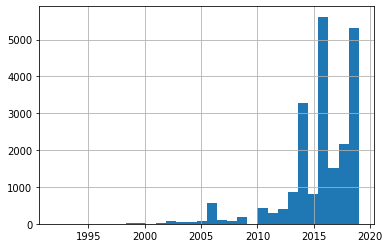

In [23]:
# Print number of observations older than 2010
old_data = combined_normalized_csv[combined_normalized_csv['TIME_PERIOD']<2010] 
print(old_data.shape)

# Visualize distribution of age of observations
combined_normalized_csv.loc[(combined_normalized_csv['TIME_PERIOD']>1990) & (combined_normalized_csv['TIME_PERIOD']<2020), 'TIME_PERIOD'].hist(bins = 30)

# Number of observations older than 2010
old_data_grouped = old_data.groupby('INDICATOR_NAME').count()

# Retrieve total number of observations
combined_normalized_csv_grouped = combined_normalized_csv.groupby('INDICATOR_NAME').count()

# Compare the number of rows older 2010 and total number of rows per indicators
old_data_analysis = old_data_grouped[['COUNTRY_ISO_3']].merge(
    right = combined_normalized_csv_grouped[['COUNTRY_ISO_3']],
    on = 'INDICATOR_NAME'
)

# Add column indicating % of obs older
old_data_analysis['OBS_PERCENT_OLDER_2010'] = round((old_data_analysis["COUNTRY_ISO_3_x"] / old_data_analysis["COUNTRY_ISO_3_y"]) * 100, 1) 


old_data_analysis.to_csv(
    path_or_buf = cwd / 'data_out' / 'percentage_old_data_per_indicator.csv',
    sep = ";"
)

# DEVELOPMENT AND TRASH AREA

### Develop ear extractor function

In [48]:
# CSV sources
api_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (ILO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (UNESCO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (WHO)") | 
    (crba_data_dictionary_source["SOURCE_TYPE"] == "API (UNICEF)")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

# # # # # # # # # # # #
# Delete again (only for temporary debugging 12.11.20)
# # # # # # # # # # # # 
api_sources = api_sources[api_sources["SOURCE_ID"] == 'S-200']

# define emty dataframe
combined_cleansed_csv = pd.DataFrame()
combined_normalized_csv = pd.DataFrame()

# Loop to extract data from API sources
for index, row in api_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Extraction section
    try:
        # Extract data
        dataframe = extract.CSVExtractor.extract(url = row["ENDPOINT_URL"])
        
        # Save raw data
        dataframe.to_csv(
            data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
            sep = ";"
            )
    
    except:
       print("There was a problem with extraction of source {} \n".format(row["SOURCE_ID"]))
    


 - - - - - 
 Extracting source S-200 

The following columns are present in the datasets, and this is the number of unique values they have. 
The column GHO has 1 unique values.
The column PUBLISHSTATE has 1 unique values.
The column YEAR has 1 unique values.
The column REGION has 6 unique values.
The column COUNTRY has 132 unique values.
The column Display Value has 3 unique values.
The column Numeric has 1 unique values.
The column Low has 1 unique values.
The column High has 1 unique values.
The column Comments has 1 unique values.
There was a problem with extraction of source S-200 



In [51]:
def extract_year_from_timeperiod(dataframe, year_col = "TIME_PERIOD", time_cov_col = "COVERAGE_TIME"):
    # Log info for user
    print("\n Calling function 'extract_year_from_timeperiod'...")

    # Determine if the time period variable is normal, or of type e.g. "2012 - 2014"
    is_time_period = re.search("-", str(dataframe[year_col].unique()))
    
    # If it is, extract the actual year 
    if is_time_period:
        # Store original column in new column
        dataframe[time_cov_col] = dataframe[year_col]

        # Define temp function (for readability rather than using lambda)
        def year_extractor_temp(period_string):
            """ From string 'startyear - endyear' extract average year
            e.g. '2014 - 2016' -->  will return 2015
            """
            result = int((int(re.findall('^\d+',period_string)[0]) + int(re.findall('\d+$',period_string)[0]))/ 2) # Return as integer, note that return of .findall is a list

            return result
        
        # Apply function to column values and overwrite column values
        dataframe[time_cov_col] =  dataframe[time_cov_col].apply(lambda x: year_extractor_temp(x))

        # Log info for user
        print("\n TIME_PERIOD column contained time periods (no atomic years). Successfully extrated year. ")

    else:
        # If time period is just containing normal year values, do nothing
        pass


In [49]:
#dataframe['YEAR'][:5]
dataframe['YEAR'][1]

(int(re.findall('^\d+',dataframe['YEAR'][1])[0]) + int(re.findall('\d+$',dataframe['YEAR'][1])[0]) )/ 2 

match = re.search("-", str(dataframe['YEAR'].unique()))
if match:
    dataframe['COVERAGE_TIME'] = dataframe['YEAR']
    def year_extractor_temp(period_string):
        """ From string 'startyear - endyear' extract average year
        e.g. '2014 - 2016' -->  will return 2015
        """
        result = int((int(re.findall('^\d+',period_string)[0]) + int(re.findall('\d+$',period_string)[0]))/ 2)

        return result
    dataframe['YEAR'] =  dataframe['YEAR'].apply(lambda x: year_extractor_temp(x))

## Extract selenium sources --> This code is stable as of 06.11.20, TO DO is to put this into a loop (which must be done in container, so I can only do it once James has looked at the issue with Chrome driver)

In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Specify location of chromedriver
cwd = os.getcwd()
driver_location = cwd + '\\chromedriver.exe'

# Add option to make it headless (so that it doesn't open an actual chrome window)
options = Options()
options.headless = True
driver = webdriver.Chrome(driver_location, chrome_options=options)

# Get HTTP response
# response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312256:NO")
# response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO::P11300_INSTRUMENT_ID:312283")
# response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312328:NO")
response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312240:NO")

# Get response
# response = driver.get(html_url)

# Retrieve the actual html
html = driver.page_source

# Soupify
soup = bs.BeautifulSoup(html)

# Extract the target table as attribute
target_table = str(
    soup.find_all("table", {"cellspacing": "0", "class": "horizontalLine"})
)

# Create dataframe with the data
raw_data = pd.read_html(io=target_table, header=0)[
    0
]  # return is a list of DFs, specify [0] to get actual DF

# Cleansing
dataframe = cleanse.Cleanser().rename_and_discard_columns(
    raw_data=raw_data,
    mapping_dictionary=mapping_dict,
    final_sdmx_col_list=sdmx_df_columns_all
)

dataframe = cleanse.Cleanser().decompose_country_footnote_ilo_normlex(
    dataframe = dataframe,
    country_name_list = country_full_list.COUNTRY_NAME
)

dataframe = cleanse.Cleanser().add_and_discard_countries(
    grouped_data=dataframe,
    crba_country_list=country_crba_list,
    country_list_full = country_full_list
)

dataframe_cleansed = cleanse.Cleanser().encode_ilo_un_treaty_data(
    dataframe = dataframe,
    treaty_source_body='ILO NORMLEX'
)

# Normalizing section
dataframe_normalized = scaler.normalizer(
    cleansed_data = dataframe_cleansed,
    sql_subset_query_string=None
)

dataframe_normalized

C:\Users\Michael\anaconda3\envs\unicef-test\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: use options instead of chrome_options



 Calling function 'rename_and_discard_columns'...

 Calling function 'add_and_discard_countries'...

 Calling function 'add_cols_fill_cells'...


,COUNTRY_NAME,ATTR_TREATY_STATUS,ATTR_FOOTNOTE_OF_SOURCE,COUNTRY_ISO_2,COUNTRY_ISO_3,_merge,RAW_OBS_VALUE,ATTR_ENCODING_LABELS,SCALED_OBS_VALUE,OBS_STATUS
0,Afghanistan,In Force,,AF,AFG,both,2,"2=Yes, 1=No; as answer to the following questi...",10.0,nan
1,Albania,In Force,Excluding Article 11 by virtue of the ratifica...,AL,ALB,both,2,"2=Yes, 1=No; as answer to the following questi...",10.0,nan
2,Algeria,In Force,,DZ,DZA,both,2,"2=Yes, 1=No; as answer to the following questi...",10.0,nan
3,Argentina,In Force,,AR,ARG,both,2,"2=Yes, 1=No; as answer to the following questi...",10.0,nan
4,Armenia,In Force,Excluding Article 11 by virtue of the ratifica...,AM,ARM,both,2,"2=Yes, 1=No; as answer to the following questi...",10.0,nan
...,...,...,...,...,...,...,...,...,...,...
192,NaN,NaN,NaN,NaN,USA,right_only,1,"2=Yes, 1=No; as answer to the following questi...",0.0,nan
193,NaN,NaN,NaN,NaN,UZB,right_only,1,"2=Yes, 1=No; as answer to the following questi...",0.0,nan
194,NaN,NaN,NaN,NaN,VUT,right_only,1,"2=Yes, 1=No; as answer to the following questi...",0.0,nan
195,NaN,NaN,NaN,NaN,VNM,right_only,1,"2=Yes, 1=No; as answer to the following questi...",0.0,nan


In [ ]:
re.sub(dataframe["ATTR_FOOTNOTE_OF_SOURCE"][5]
       
# Speifically for ILO NORMLEX - extract country name if additonal info is given
#dataframe["ATTR_FOOTNOTE_OF_SOURCE"] = dataframe["COUNTRY_NAME"]
#dataframe["COUNTRY_NAME"] = dataframe["COUNTRY_NAME"].apply(extract_country_name)
#dataframe["ATTR_FOOTNOTE_OF_SOURCE"] = dataframe.apply(lambda x: re.sub(x['COUNTRY_NAME'], "", x["ATTR_FOOTNOTE_OF_SOURCE"]), 1)


In [ ]:
import requests
import bs4 as bs
import pandas as pd
import selenium
import os
from pathlib import Path
from selenium import webdriver

# cwd = Path('.')
cwd = os.getcwd()

# Current working directory
driver_location = cwd + '\\geckodriver.exe'

print(driver_location)

# Open the targete html. Must be done with selenium, because it doesnt work with normal URL request
#driver = webdriver.Firefox(executable_path="D:/Documents/2020/28_UNICEF/10_working_repo/data-etl/geckodriver.exe")
driver = webdriver.Firefox(executable_path=driver_location)

# Get HTTP response
response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312256:NO")


## World policy analsis centre loop
(deprecated, already taken into the operational mode above)

In [19]:
# 1. Create a flat file of all WPA sources
# Read and join all world policy analysis centre data
wpa_child_labor = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_8, S_9' / 'WORLD_child_labor.xls'
)

wpa_childhood = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_10, S_13, S_36, S_45, S_49' / 'WORLD_Dataset_Childhood_4.16.15.xls'
)

wpa_adult_labor = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_40, S_41, S_63, S_64, S_65, S_66, S_67, S_68' / 'WORLD_Dataset_Adult_Labor_9.17.2018.xls'
)

wpa_discrimination = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_42, S_43, S_44' / 'WORLD_discrimination_at_work.xls'
)

# Create list to write a loop
wpa_combined_list=[
    wpa_childhood,
    wpa_adult_labor,
    wpa_discrimination
 ]

# Loop to join all dataframes
wpa_combined = wpa_child_labor

for df in wpa_combined_list:
    wpa_combined = wpa_combined.merge(
        right=df,
        on=['iso2', 'iso3']
    )

# 2. Loop

# WPA sources
wpa_sources = crba_data_dictionary_source[
    (crba_data_dictionary_source["SOURCE_BODY"] == "World Policy Analysis Centre")
].merge(
    right = crba_data_dictionary_snapshot,
    on = "SOURCE_ID"
).merge(
    right = crba_data_dictionary_indicator,
    on = 'INDICATOR_ID'
)

#print(wpa_sources)

# # # # # # # Temp, delete this again # # # # 
wpa_sources = wpa_sources[wpa_sources["SOURCE_ID"] == 'S-49']
# combined_cleansed_csv = pd.DataFrame()
# combined_normalized_csv = pd.DataFrame()

#print(wpa_sources["SOURCE_ID"] == 'S-92')

# Loop to extract data from API sources
for index, row in wpa_sources.iterrows():
    # Log
    print("\n - - - - - \n Extracting source {} \n".format(row["SOURCE_ID"]))
    
    # Exraction section
    #try:
    # Extract data 
    # Log that we are entering cleasning
    print("\n Extracting data and store it as raw data")

    dataframe = wpa_combined[['iso3', row['WPA_OBS_RAW_COL']]] 
    dataframe['TIME_PERIOD'] = row['WPA_YEAR_COL'] 

    print(dataframe.head(50))

    # Save dataframe
    dataframe.to_csv(
        data_sources_raw / str(row["SOURCE_ID"] + "_raw.csv"),
        sep = ";")
    #except:
    print("There was an issue with source {}".format(row["SOURCE_ID"]))
    
    # Log that we are entering cleasning
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))
    
    # Cleansing 
    print("\n - - - - - \n Cleansing source {} \n".format(row["SOURCE_ID"]))

    dataframe = cleanse.Cleanser().rename_and_discard_columns(
        raw_data=dataframe,
        mapping_dictionary=mapping_dict,
        final_sdmx_col_list=sdmx_df_columns_all
    )

    print(dataframe['RAW_OBS_VALUE'].unique())

    dataframe = cleanse.Cleanser().add_and_discard_countries(
        grouped_data=dataframe,
        crba_country_list=country_crba_list,
        country_list_full = country_full_list
    )

    dataframe = cleanse.Cleanser().add_cols_fill_cells(
        grouped_data_iso_filt=dataframe,
        dim_cols=sdmx_df_columns_dims,
        time_cols=sdmx_df_columns_time,
        indicator_name_string=row["INDICATOR_NAME_x"],
        index_name_string=row["INDEX"],
        issue_name_string=row["ISSUE"],
        category_name_string=row["CATEGORY"],
        indicator_code_string=row["INDICATOR_CODE"],
        indicator_source_string=row["ADDRESS"],
        indicator_source_body_string=row["SOURCE_BODY"],
        indicator_description_string=row["INDICATOR_DESCRIPTION"],
        indicator_explanation_string=row["INDICATOR_EXPLANATION"],
        indicator_data_extraction_methodology_string=row["EXTRACTION_METHODOLOGY"],
        source_title_string=row["SOURCE_TITLE"],
        source_api_link_string=row["ENDPOINT_URL"]
    )

    dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
        dataframe = dataframe,
        encoding_string = row["VALUE_ENCODING"],
        encoding_labels = row["VALUE_LABELS"]
    )

    cleanse.Cleanser().create_log_report(
        cleansed_data=dataframe_cleansed
    )

    
    # Append dataframe to combined dataframe
    combined_cleansed_csv = combined_cleansed_csv.append(
        other = dataframe_cleansed
    )
    

    # Save cleansed data
    dataframe_cleansed.to_csv(
        data_sources_cleansed / str(row["SOURCE_ID"] + "_cleansed.csv"),
        sep = ";")

    # Normalizing
    dataframe_normalized = scaler.normalizer(
        cleansed_data = dataframe_cleansed,
        sql_subset_query_string=row["DIMENSION_VALUES_NORMALIZATION"],
        # dim_cols=sdmx_df_columns_dims,
        variable_type = row["VALUE_LABELS"],
        is_inverted = row["INVERT_NORMALIZATION"],
        whisker_factor=1.5,
        raw_data_col="RAW_OBS_VALUE",
        scaled_data_col_name="SCALED_OBS_VALUE",
        maximum_score=10,
        )

    dataframe_normalized.to_csv(
        data_sources_normalized / str(row["SOURCE_ID"] + "_normalized.csv"),
        sep = ";")

    # Append dataframe to combined dataframe
    combined_normalized_csv = combined_normalized_csv.append(
        other = dataframe_normalized
    )



 - - - - - 
 Extracting source S-49 


 Extracting data and store it as raw data
   iso3  minwage_ppp  TIME_PERIOD
0   AFG          4.0         2014
1   ALB          5.0         2014
2   DZA          5.0         2014
3   AND          NaN         2014
4   AGO          3.0         2014
5   ATG          5.0         2014
6   ARG          5.0         2014
7   ARM          4.0         2014
8   AUS          5.0         2014
9   AUT          5.0         2014
10  AZE          4.0         2014
11  BHS          5.0         2014
12  BHR          1.0         2014
13  BGD          2.0         2014
14  BRB          5.0         2014
15  BLR          5.0         2014
16  BEL          5.0         2014
17  BLZ          5.0         2014
18  BEN          3.0         2014
19  BTN          4.0         2014
20  BOL          4.0         2014
21  BIH          5.0         2014
22  BWA          4.0         2014
23  BRA          5.0         2014
24  BRN          1.0         2014
25  BGR          5.0         2014


In [9]:
# Read and join all world policy analysis centre data
wpa_child_labor = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_8, S_9' / 'WORLD_child_labor.xls'
)

wpa_childhood = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_10, S_13, S_36, S_45, S_49' / 'WORLD_Dataset_Childhood_4.16.15.xls'
)

wpa_adult_labor = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_40, S_41, S_63, S_64, S_65, S_66, S_67, S_68' / 'WORLD_Dataset_Adult_Labor_9.17.2018.xls'
)

wpa_discrimination = pd.read_excel(
    io = data_in / 'data_raw_manually_extracted' / 'S_42, S_43, S_44' / 'WORLD_discrimination_at_work.xls'
)

# Create list to write a loop
wpa_combined_list=[
    wpa_childhood,
    wpa_adult_labor,
    wpa_discrimination
 ]

# Loop to join all dataframes
wpa_combined = wpa_child_labor

for df in wpa_combined_list:
    wpa_combined = wpa_combined.merge(
        right=df,
        on=['iso2', 'iso3']
    )

s8_raw = wpa_combined[['iso3', 'admiss_age']]
s8_raw['TIME_PERIOD'] = 2019

s9_raw = wpa_combined[['iso3', 'light_age']]
s9_raw['TIME_PERIOD'] = 2019

s13_raw = wpa_combined[['iso3', 'cl_haz_minage']]
s13_raw['TIME_PERIOD'] = 2014

s36_raw = wpa_combined[['iso3', 'minwage_leg']]
s36_raw['TIME_PERIOD'] = 2014

s41_raw = wpa_combined[['iso3', 'sickleave_duration']]
s41_raw['TIME_PERIOD'] = 2014

s42_raw = wpa_combined[['iso3', 'promdemo_sex']]
s42_raw['TIME_PERIOD'] = 2014

s67_raw = wpa_combined[['iso3', 'paternal_leave']]
s67_raw['TIME_PERIOD'] = 2014
# # # # 


s10_raw = wpa_combined[['iso3', 'edu_comp_begsec']]
s10_raw['TIME_PERIOD'] = 2019

s10_raw

dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
    dataframe = s10_raw,
    encoding_string = '2 = 5.0; 1= 1.0',
    na_encodings='No data',
    obs_raw_value_source='edu_comp_begsec',
    obs_raw_value_target="RAW_OBS_VALUE",
    encoding_labels='2 = Compulsory; 1= Not compulsory; 0 = No data'
)

# dataframe_cleansed['RAW_OBS_VALUE'].unique()
dataframe_cleansed


# # # ## 
"""
s40_raw = wpa_combined[['iso3', 'paid_anlv']]
s40_raw['TIME_PERIOD'] = 2019

s40_raw

dataframe_cleansed = cleanse.Cleanser().encode_categorical_variables(
    dataframe = s40_raw,
    encoding_string = '20 days or more=5.0; 15-19 days=4.0; Set externally=3.0; 5-9 days = 2.0; No paid annual leave = 1.0',
    na_encodings='No data',
    obs_raw_value_source='paid_anlv',
    obs_raw_value_target="RAW_OBS_VALUE"
)

dataframe_cleansed['RAW_OBS_VALUE'].unique()
"""
dataframe_cleansed


 Calling function 'encode_categorical_variables'...


,iso3,edu_comp_begsec,TIME_PERIOD,RAW_OBS_VALUE,ATTR_ENCODING_LABELS
0,AFG,5.0,2019,2,2 = Compulsory; 1= Not compulsory; 0 = No data
1,ALB,5.0,2019,2,2 = Compulsory; 1= Not compulsory; 0 = No data
2,DZA,5.0,2019,2,2 = Compulsory; 1= Not compulsory; 0 = No data
3,AND,5.0,2019,2,2 = Compulsory; 1= Not compulsory; 0 = No data
4,AGO,1.0,2019,1,2 = Compulsory; 1= Not compulsory; 0 = No data
...,...,...,...,...,...
188,VEN,5.0,2019,2,2 = Compulsory; 1= Not compulsory; 0 = No data
189,VNM,1.0,2019,1,2 = Compulsory; 1= Not compulsory; 0 = No data
190,YEM,5.0,2019,2,2 = Compulsory; 1= Not compulsory; 0 = No data
191,ZMB,1.0,2019,1,2 = Compulsory; 1= Not compulsory; 0 = No data


## GHG

problem: 

* Cannot use pd_json_normalize --> It won't unnest it becaust he years and actual values are given in [] rather than {}
* Stopped here: Must replace the character (but for that it is necessary to convert json to string and back)
* Next challnge: Get all data (and not only page 1) --> Main problem is that the API is not working, i.e. can't specify paramters

Stopped here 10.11.20 --> Need to get rid of "[]" signgs for 

In [57]:
dataframe_json = requests.get("https://www.climatewatchdata.org/api/v1/data/historical_emissions").text

dataframe_json_cleansed = dataframe_json.replace('[', '{').replace(']','}')
json_file = json.dumps(dataframe_json_cleansed)
# some_var = json.loads(dataframe_json_cleansed)
# type(some_var)
# pd.json_normalize(json_file)

In [37]:
#dataframe = extract.CSVExtractor.extract(url = "https://www.climatewatchdata.org/api/v1/data/historical_emissions")

dataframe_json = requests.get("https://www.climatewatchdata.org/api/v1/data/historical_emissions").json()

cleaned_json = dataframe_json['data']# .replace('[', '{').replace
type(cleaned_json)
"""
# with open(dataframe_json, 'r') as file:
    content = file.read()
    clean = content.replace(']', '}')  # cleanup here
    json_data = json.loads(clean)
"""

# dataframe_2 = pd.json_normalize(dataframe_json['data'], max_level=5)

# dataframe_3 = pd.json_normalize(dataframe_json['data)


#dataframe_3

cleaned_json[5]

{'id': 518203,
 'iso_code3': 'AFG',
 'country': 'Afghanistan',
 'data_source': 'CAIT',
 'sector': 'Total excluding LUCF',
 'gas': 'CH4',
 'unit': 'MtCO₂e',
 'emissions': [{'year': 1990, 'value': 8.97},
  {'year': 1991, 'value': 9.07},
  {'year': 1992, 'value': 9.0},
  {'year': 1993, 'value': 8.9},
  {'year': 1994, 'value': 8.97},
  {'year': 1995, 'value': 9.15},
  {'year': 1996, 'value': 9.93},
  {'year': 1997, 'value': 10.6},
  {'year': 1998, 'value': 11.1},
  {'year': 1999, 'value': 11.87},
  {'year': 2000, 'value': 10.59},
  {'year': 2001, 'value': 9.36},
  {'year': 2002, 'value': 11.21},
  {'year': 2003, 'value': 11.56},
  {'year': 2004, 'value': 11.47},
  {'year': 2005, 'value': 11.68},
  {'year': 2006, 'value': 14.89},
  {'year': 2007, 'value': 18.1},
  {'year': 2008, 'value': 22.19},
  {'year': 2009, 'value': 25.43},
  {'year': 2010, 'value': 30.04},
  {'year': 2011, 'value': 39.48},
  {'year': 2012, 'value': 48.78},
  {'year': 2013, 'value': 58.13},
  {'year': 2014, 'value': 67

## Extract the countries

In [ ]:
import bs4 as bs
import pandas
import os
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Specify location of chromedriver
cwd = os.getcwd()
driver_location = cwd + '\\chromedriver.exe'

# Add option to make it headless (so that it doesn't open an actual chrome window)
options = Options()
options.headless = True
driver = webdriver.Chrome(driver_location, chrome_options=options)

# Get HTTP response
# response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO:11300:P11300_INSTRUMENT_ID:312256:NO")
response = driver.get("https://www.ilo.org/dyn/normlex/en/f?p=NORMLEXPUB:11300:0::NO::P11300_INSTRUMENT_ID:312283")

# Get response
# response = driver.get(html_url)

# Retrieve the actual html
html = driver.page_source

# Soupify
soup = bs.BeautifulSoup(html)

# Extract the target table as attribute
target_table = str(
    soup.find_all("table", {"cellspacing": "0", "class": "horizontalLine"})
)

# Create dataframe with the data
raw_data = pd.read_html(io=target_table, header=0)[
    0
]  # return is a list of DFs, specify [0] to get actual DF

# Cleansing
dataframe = cleanse.Cleanser().rename_and_discard_columns(
    raw_data=raw_data,
    mapping_dictionary=mapping_dict,
    final_sdmx_col_list=sdmx_df_columns_all
)

# dataframe

In [ ]:
def extract_country_name(cell, country_name_list = country_full_list.COUNTRY_NAME):
    # Determine which country in the full country list is contained in string
    subset_list = [x in cell for x in country_name_list]
    
    # Sometimes several country names match, but we need exactly one
    if sum(subset_list)==0:
        print("No country name match")
    elif sum(subset_list)==1:
        # Retrieve the actual country name
        country_name = country_name_list[subset_list].item()
    else:
        # Retrieve the actual country name
        country_name = country_name_list[subset_list].iloc[0]
    
    return country_name

In [ ]:
country_full_list.COUNTRY_NAME[subset_list].item()

In [ ]:

country_full_list
    
subset_list = [x in dataframe.COUNTRY_NAME[2] for x in country_full_list.COUNTRY_NAME]

dataframe.COUNTRY_NAME[2] = country_full_list.loc[subset_list, "COUNTRY_NAME"].item()

dataframe

### Extract UN Treaty data

In [ ]:
import requests
import urllib
import bs4 as bs
import pandas as pd

raw_html_1 = requests.get("https://treaties.un.org/pages/ViewDetails.aspx?src=TREATY&mtdsg_no=XVIII-12-a&chapter=18&clang=_en")

# raw_html_1.text
raw_html_2 = urllib.request.urlopen("https://treaties.un.org/pages/ViewDetails.aspx?src=TREATY&mtdsg_no=XVIII-12-a&chapter=18&clang=_en")

print(raw_html_1)
print(raw_html_2)

soup = bs.BeautifulSoup(raw_html_1.text, features="lxml")
#soup_2 = bs.BeautifulSoup(raw_html_2, features="lxml")

#soup_2
# soup_1

# Extract the target table as attribute
target_table = str(
    soup.find_all(
        "table",
        {"class": "table table-striped table-bordered table-hover table-condensed"},
    )
)

# Create dataframe with the data
raw_data = pd.read_html(io=target_table, header=0)[
    0
]

raw_data

In [16]:
# Identify duplicates

# Checking to see if there are any duplicate entries
duplicates = combined_normalized_csv[combined_normalized_csv.duplicated(
    subset = [
        "COUNTRY_ISO_3",
        "TIME_PERIOD",
        "COUNTRY_NAME",
        "COUNTRY_ISO_2",
        "RAW_OBS_VALUE",
        "DIM_SEX",
        "DIM_EDU_LEVEL",
        "DIM_AGE",
        "DIM_AGE_GROUP",
        "DIM_MANAGEMENT_LEVEL",
        "DIM_AREA_TYPE",
        "DIM_QUANTILE",
        "DIM_SDG_INDICATOR",
        "DIM_OCU_TYPE",
        "DIM_REP_TYPE",
        "DIM_SECTOR",
        "DIM_ALCOHOL_TYPE",
        "INDICATOR_CODE"
        ],
    keep = False

)]

duplicates.to_csv(
    path_or_buf = cwd / 'data_out' / 'duplicates.csv',
    sep = ";"
)